In [1]:
import os 
import cv2
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, TimeDistributed, Conv2D
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.callbacks import ModelCheckpoint

In [2]:
datadir_noisy = "C:\\Users\\z3fayyaz\\Desktop\\real\\"
data_clean = "C:\\Users\\z3fayyaz\\Desktop\\mean\\"

test_output = "C:\\Users\\z3fayyaz\\Desktop\\Results\\"

In [11]:
arr = os.listdir('C:\\Users\\z3fayyaz\\Desktop\\real\\')
print(arr)

['Canon5D2_5_160_3200_chair_11_real.JPG', 'Canon5D2_5_160_3200_chair_14_real.JPG', 'Canon5D2_5_160_3200_chair_5_real.JPG', 'Canon5D2_5_160_3200_plug_11_real.JPG', 'Canon5D2_5_160_3200_plug_12_real.JPG', 'Canon5D2_5_160_6400_bicycle_10_real.JPG', 'Canon5D2_5_160_6400_bicycle_6_real.JPG', 'Canon5D2_5_160_6400_bicycle_8_real.JPG', 'Canon5D2_5_160_6400_circuit_11_real.JPG', 'Canon5D2_5_160_6400_circuit_3_real.JPG', 'Canon5D2_5_160_6400_circuit_8_real.JPG', 'Canon5D2_5_160_6400_desk_10_real.JPG', 'Canon5D2_5_160_6400_desk_4_real.JPG', 'Canon5D2_5_160_6400_desk_5_real.JPG', 'Canon5D2_5_160_6400_desk_7_real.JPG', 'Canon5D2_5_160_6400_reciever_13_real.JPG', 'Canon5D2_5_160_6400_reciever_1_real.JPG', 'Canon5D2_5_160_6400_reciever_2_real.JPG', 'Canon5D2_5_160_6400_reciever_4_real.JPG', 'Canon5D2_5_160_6400_reciever_6_real.JPG', 'Canon5D2_5_160_6400_reciever_8_real.JPG', 'Canon5D2_5_200_3200_fruit_11_real.JPG', 'Canon5D2_5_200_3200_fruit_12_real.JPG', 'Canon5D2_5_200_3200_fruit_14_real.JPG', 'Can

In [28]:
def create_data(datadir):
    training_validation_data = []
    for img in os.listdir(datadir):
        new_array = cv2.imread(os.path.join(datadir, img))
        #new_array = cv2.resize(img_array, (image_size, image_size))
        new_array.astype('float32')
        training_validation_data.append(new_array)
    return training_validation_data

In [29]:
arr = create_data(datadir_noisy)

In [30]:
len(arr)

100

In [4]:
# We have previously read all images from datadir as training + validation images, here we perform the split
# Default value for split is 85% training and 15% validation
def training_validation_split(training_validation, split=0.85):
    print("Using " + str(split * 100) + "% " + "Train and " + str(100 - (split * 100)) + "% " "Validation")
    print("Total Training + Validation Length: " + str(len(training_validation)))
    numtosplit = int(split * (len(training_validation)))
    training_data = training_validation[:numtosplit]
    validation_data = training_validation[numtosplit:]
    print("Training Data Length: " + str(len(training_data)))
    print("Validation Data Length: " + str(len(validation_data)))
    return training_data, validation_data

In [5]:
# Call this function when we want to inspect 1 image as: degraded, ground truth, and predicted
# "type" argument refers to setting the title of the subplot as "Testing Image" or "Training Image"
def create_subplots(degraded, ground_truth, predicted, type):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(11, 11))
    # Plot 1: Degraded Image
    ax1.imshow(degraded, cmap="gray")
    ax1.title.set_text('Degraded Image')

    # Plot 2: Ground Truth Image
    ax2.imshow(ground_truth, cmap="gray")
    ax2.title.set_text('Ground truth Image')

    # Plot 3: Predicted Clean Image
    ax3.imshow(predicted, cmap="gray")
    ax3.title.set_text('Predicted Image')
    if type == "test":
        fig.suptitle("Testing Image")
    elif type == "train":
        fig.suptitle("Training Image")
    return fig

def average(lst):
    return sum(lst) / len(lst)

In [6]:
# Calculate the PSNR and SSIM metrics using sklearn built-in calculations
# All calculations are performed with respect to the ground_truth image
# For both SSIM and PSNR, we aim for a large positive difference
# If the difference is positive, our network is learning. Else, the predicted image is worse quality than degraded
def psnr_ssim_metrics(ground_truth, predicted, degraded):
    # PSNR
    psnr_degraded = peak_signal_noise_ratio(ground_truth, degraded)
    psnr_predicted = peak_signal_noise_ratio(ground_truth, predicted)
    psnr_difference = psnr_predicted - psnr_degraded
    # SSIM
    ssim_degraded = structural_similarity(ground_truth, degraded)
    ssim_predicted = structural_similarity(ground_truth, predicted)
    ssim_difference = ssim_predicted - ssim_degraded
    return psnr_degraded, psnr_predicted, psnr_difference, ssim_degraded, ssim_predicted, ssim_difference

In [42]:
# MODEL 4 5 CNN
# Transpose the input shape replacing rows with columns and columns with rows
# Return sequences is TRUE as we want an output for every timestep, and not a "many-to-one" output
# Merge_mode is set to AVERAGE - in order to maintain dimensionality (256,256) [default is CONCAT]
def train_model(image_size=512):
    
    size_GRU = image_size*3 
    
    inputs = Input(shape=(image_size, image_size, 3))   

    
    inputs_transposed = tf.transpose(inputs, perm=[0, 2, 1, 3])   
    inputs_t = keras.layers.Reshape((512, 1536))(inputs_transposed)
    
    output_1 = (Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave"))(inputs_t)
    # The input of layer 2 is the output of layer 0 [transpose] SUBTRACT the output of layer 1
    input_2 = tf.keras.layers.Subtract()([inputs_t, output_1])
    
    
    output_2 = (Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave"))(input_2)
    input_3 = keras.layers.Subtract()([inputs_t, output_2])
    output_3 = (Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave"))(input_3)
    input_4 = keras.layers.Subtract()([inputs_t, output_3])
    output_4 = (Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave"))(input_4)
    input_5 = keras.layers.Subtract()([inputs_t, output_4])
    output_5 = (Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave"))(input_5)
    input_6 = keras.layers.Subtract()([inputs_t, output_5])
    output_6 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_6)
    input_7 = keras.layers.Subtract()([inputs_t, output_6])
    output_7 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_7)
    input_8 = keras.layers.Subtract()([inputs_t, output_7])
    output_8 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_8)
    input_9 = keras.layers.Subtract()([inputs_t, output_8])
    output_9 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_9)
    input_10 = keras.layers.Subtract()([inputs_t, output_9])
    output_10 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_10)
    input_11 = keras.layers.Subtract()([inputs_t, output_10])
    output_11 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_11)
    input_12 = keras.layers.Subtract()([inputs_t, output_11])
    output_12 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_12)
    input_13 = keras.layers.Subtract()([inputs_t, output_12])
    output_13 = Bidirectional(GRU(size_GRU, return_sequences=True), merge_mode="ave")(input_13)
    # Perform TimeDistributed Operation to final output of GRU
    output_GRU = TimeDistributed(Dense(size_GRU))(output_13)
    # Transpose the image once again, giving us original dimensionality

    # We aim for the real_output to be as close as possible to 'z' -> the Clean Image
    # The clean image is the dirty image [Input] SUBTRACT the noise [Output of the Network (output_GRU)]  
    
    output_GRU = tf.transpose(output_GRU, perm=[0, 2, 1])
    output_GRU = keras.layers.Reshape((512,512,3))(output_GRU)
        
    gru_output = tf.keras.layers.Subtract()([inputs, output_GRU])
    #conv1_input = tf.expand_dims(gru_output, -1)
    # cnn 5x5 kernel. relu activation
    conv1 = Conv2D(32, kernel_size=5, activation='relu', padding='same', strides=1)(gru_output)
    conv2 = Conv2D(32, kernel_size=3, activation='relu', padding='same', strides=1)(conv1)
    conv3 = Conv2D(32, kernel_size=3, activation='relu', padding='same', strides=1)(conv2)
    conv4 = Conv2D(32, kernel_size=3, activation='relu', padding='same', strides=1)(conv3)
    conv5 = Conv2D(32, kernel_size=3, activation='relu', padding='same', strides=1)(conv4)
    conv6 = Conv2D(32, kernel_size=3, activation='relu', padding='same', strides=1)(conv5)
    conv7 = Conv2D(32, kernel_size=3, activation='relu', padding='same', strides=1)(conv6)
    conv8 = Conv2D(1, kernel_size=3, activation='relu', padding='same', strides=1)(conv7)
    # cnn 3x3
    # cnn 3x3.
    # subtract inputs, output of cnn => final output
    #cnn_output = tf.squeeze(conv8, [3])
    cnn_output = conv8
    real_output = tf.keras.layers.Subtract()([gru_output, cnn_output])

    model = Model(inputs=inputs, outputs=real_output)
    model.summary()
    print("Model Compiled")
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model

In [43]:
# We separate the datadir images into Training Data and Validation Data
print("Creating Training and Validation Data...")
TRAIN_target = create_data(data_clean)
TRAIN_input = create_data(datadir_noisy)

training_data_target, validation_data_target = training_validation_split(TRAIN_target)
training_data_input, validation_data_input = training_validation_split(TRAIN_input)

training_data_target = np.array(training_data_target)
training_data_input = np.array(training_data_input)
validation_data_target = np.array(validation_data_target)
validation_data_input = np.array(validation_data_input)

Creating Training and Validation Data...
Using 85.0% Train and 15.0% Validation
Total Training + Validation Length: 100
Training Data Length: 85
Validation Data Length: 15
Using 85.0% Train and 15.0% Validation
Total Training + Validation Length: 100
Training Data Length: 85
Validation Data Length: 15


In [41]:
training_data_target[4].shape

(512, 512, 3)

In [47]:
training_target_FIXED = []

for i in range(len(training_data_target)):
    training_target_FIXED.append(training_data_target[i])

training_input_FIXED = []

for i in range(len(training_data_input)):
    training_input_FIXED.append(training_data_input[i])

validation_input_FIXED = []

for i in range(len(validation_data_input)):
    validation_input_FIXED.append(validation_data_input[i])

validation_target_FIXED = []

for i in range(len(validation_data_target)):
    validation_target_FIXED.append(validation_data_target[i])

In [45]:
filepath = "C:\\Users\\z3fayyaz\\Desktop\\Rain100L\\model_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callback_list = [checkpoint]

loss_train = []
loss_val = []

model = train_model(512)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.transpose_3 (TFOp  (None, 512, 512, 3)  0          ['input_3[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 reshape_3 (Reshape)            (None, 512, 1536)    0           ['tf.compat.v1.transpose_3[0][0]'
                                                                 ]                          

In [48]:
X = training_input_FIXED
X = np.array(X)
z = training_target_FIXED
z = np.array(z)
X_validation = validation_input_FIXED
X_validation = np.array(X_validation)
z_validation = validation_target_FIXED
z_validation = np.array(z_validation)

X = np.array(X)
z = np.array(z)
X_validation = np.array(X_validation)
z_validation = np.array(z_validation)
print("Reshaping Arrays... Done")

Reshaping Arrays... Done


In [49]:
def convert2RGB(image_list):
    for i in range (len(image_list)):
        image_list[i] = cv2.cvtColor(image_list[i], cv2.COLOR_RGB2BGR)

In [50]:
convert2RGB(X)

In [51]:
convert2RGB(z)

In [52]:
convert2RGB(X_validation)

In [53]:
convert2RGB(z_validation)

(85, 512, 512, 3)
(85, 512, 512, 3)
(15, 512, 512, 3)
(15, 512, 512, 3)


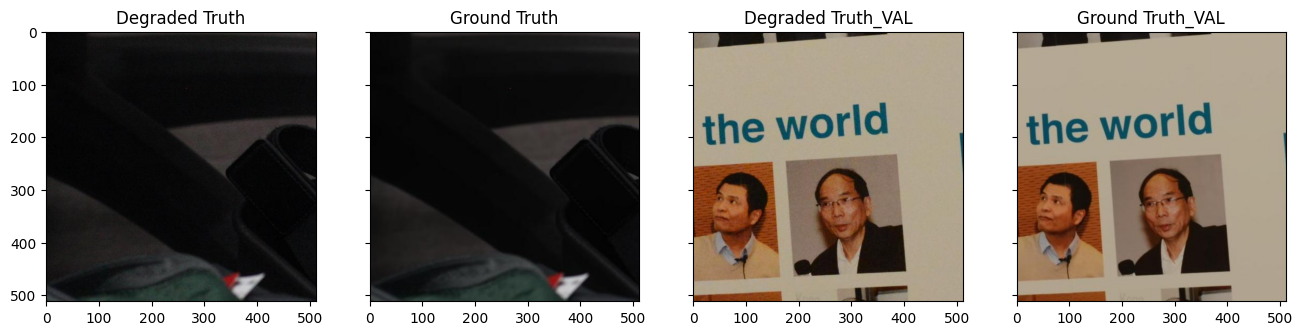

In [54]:
print(X.shape)
print(z.shape)
print(X_validation.shape)
print(z_validation.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey =True, figsize=(16,13))
#Plot 1: Clean Training Image
ax1.imshow(X[0])
ax1.title.set_text('Degraded Truth')

#Plot 2: Degraded Training Image
ax2.imshow(z[0])
ax2.title.set_text('Ground Truth')

#Plot 3: Clean Validation Image
ax3.imshow(X_validation[0])
ax3.title.set_text('Degraded Truth_VAL')

#Plot 2: Degraded Validation Image
ax4.imshow(z_validation[0])
ax4.title.set_text('Ground Truth_VAL')

In [ ]:
# Calculate loss
loss_metrics = model.fit(X, z,
                         batch_size=20,
                         epochs=150,
                         validation_data=(X_validation, z_validation),
                         callbacks=callback_list
                         )

Epoch 1/150
